# Script 1: Importing Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset")

print("Path to dataset files:", path)

# Define dataset paths
frames_dir = path + "/frames"
masks_dir = path + "/masks"

print("Frames directory:", frames_dir)
print("Masks directory:", masks_dir)


Path to dataset files: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset
Frames directory: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames
Masks directory: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks


# Script 2: Randomly Display 5 Frame-Mask Pairs

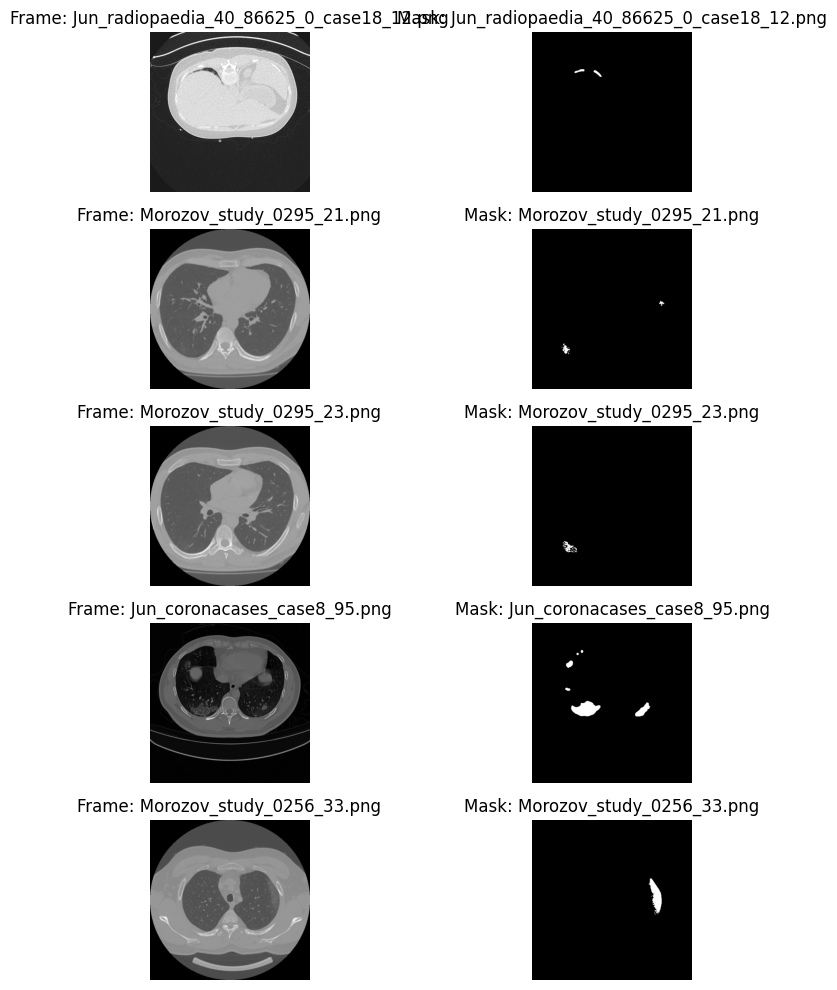

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset paths
frames_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames"
masks_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks"

# Get a list of all frame files with corresponding masks
frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(os.path.join(masks_dir, f))
])

if not frame_files:
    raise ValueError("No matching frame and mask files found.")

# Randomly select 5 frame-mask pairs
sample_files = random.sample(frame_files, min(len(frame_files), 5))

# Display the images and their corresponding masks
plt.figure(figsize=(10, 10))

for i, file_name in enumerate(sample_files):
    # Load frame and mask
    frame_path = os.path.join(frames_dir, file_name)
    mask_path = os.path.join(masks_dir, file_name)
    img_frame = Image.open(frame_path)
    img_mask = Image.open(mask_path)
    
    # Display frame
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(img_frame, cmap='gray')
    plt.title(f"Frame: {file_name}")
    plt.axis('off')
    
    # Display mask
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(img_mask, cmap='gray')
    plt.title(f"Mask: {file_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Script 3: Splitting Dataset and Organizing Files

In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image

# Define dataset paths
frames_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames"
masks_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks"

# Create output directories
output_base_dir = "/kaggle/working"
output_dirs = {
    "train": {
        "frames": os.path.join(output_base_dir, "train/frames"),
        "masks": os.path.join(output_base_dir, "train/masks"),
    },
    "validation": {
        "frames": os.path.join(output_base_dir, "validation/frames"),
        "masks": os.path.join(output_base_dir, "validation/masks"),
    },
    "test": {
        "frames": os.path.join(output_base_dir, "test/frames"),
        "masks": os.path.join(output_base_dir, "test/masks"),
    },
}

for paths in output_dirs.values():
    os.makedirs(paths["frames"], exist_ok=True)
    os.makedirs(paths["masks"], exist_ok=True)

# Get all frame files with corresponding masks
frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(os.path.join(masks_dir, f))
])

# Split the data: 80% train, 10% validation, 10% test (adjust as needed)
train_files, temp_files = train_test_split(frame_files, test_size=0.2, random_state=42)
validation_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files to respective directories and augment training data
def copy_files(file_list, dataset_type):
    for file_name in file_list:
        # Copy the original frame and mask
        shutil.copyfile(
            os.path.join(frames_dir, file_name),
            os.path.join(output_dirs[dataset_type]["frames"], file_name)
        )
        shutil.copyfile(
            os.path.join(masks_dir, file_name),
            os.path.join(output_dirs[dataset_type]["masks"], file_name)
        )
        
        # If this is the training set, apply augmentations:
        if dataset_type == "train":
            # Open the original image and mask using PIL
            image = Image.open(os.path.join(frames_dir, file_name))
            mask = Image.open(os.path.join(masks_dir, file_name))
            
            base, ext = os.path.splitext(file_name)
            
            # Augmentation 1: With 50% chance, apply fixed-angle rotation (choose randomly from 90, 180, 270)
            if random.random() < 0.5:
                angle_fixed = random.choice([90, 180, 270])
                image_rot_fixed = image.rotate(angle_fixed, expand=True)
                mask_rot_fixed = mask.rotate(angle_fixed, expand=True)
                new_name_fixed = f"{base}_rot{angle_fixed}{ext}"
                image_rot_fixed.save(os.path.join(output_dirs[dataset_type]["frames"], new_name_fixed))
                mask_rot_fixed.save(os.path.join(output_dirs[dataset_type]["masks"], new_name_fixed))
            
            # Augmentation 2: With 50% chance, apply random rotation between -30 and 30 degrees
            if random.random() < 0.5:
                angle_random = random.uniform(-30, 30)
                image_rot_random = image.rotate(angle_random, expand=True)
                mask_rot_random = mask.rotate(angle_random, expand=True)
                new_name_random = f"{base}_rot{int(angle_random)}{ext}"
                image_rot_random.save(os.path.join(output_dirs[dataset_type]["frames"], new_name_random))
                mask_rot_random.save(os.path.join(output_dirs[dataset_type]["masks"], new_name_random))

# Copy files (with augmentation for training)
copy_files(train_files, "train")
copy_files(validation_files, "validation")
copy_files(test_files, "test")

# Print dataset counts
dataset_counts = {
    "train": len(os.listdir(output_dirs["train"]["frames"])),
    "validation": len(os.listdir(output_dirs["validation"]["frames"])),
    "test": len(os.listdir(output_dirs["test"]["frames"])),
}

print("Dataset Counts:")
for dataset_type, count in dataset_counts.items():
    print(f"{dataset_type.capitalize()} Set: {count} images")


Dataset Counts:
Train Set: 4328 images
Validation Set: 273 images
Test Set: 273 images


# Script 4: Training the U-Net Model

In [4]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * K.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)


In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Note:
# 1. Make sure you pass validation data to model.fit() so that 'val_loss' exists.
# 2. Ensure h5py is installed if you want to save your model in .h5 format. 
#    Alternatively, you can change the file extension to '.keras'.

# Callback to reduce learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Callback to stop training early if the validation loss does not improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # or 'best_model.keras' if you prefer the SavedModel format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [9]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


Loading data from frames: 100%|██████████| 273/273 [00:02<00:00, 109.55it/s]


Epoch 1/50


I0000 00:00:1742895243.575124     103 service.cc:145] XLA service 0x7a3f94002710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742895243.575185     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/271 ━━━━━━━━━━━━━━━━━━━━ 3:05:54 41s/step - dice_coefficient: 0.0205 - iou_coefficient: 0.0104 - loss: 0.7860

I0000 00:00:1742895274.375544     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1742895274.419493     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - dice_coefficient: 0.0868 - iou_coefficient: 0.0462 - loss: 0.5880
Epoch 1: val_loss improved from inf to 0.54583, saving model to best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 103s 228ms/step - dice_coefficient: 0.0870 - iou_coefficient: 0.0463 - loss: 0.5878 - val_dice_coefficient: 0.0277 - val_iou_coefficient: 0.0142 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - dice_coefficient: 0.2193 - iou_coefficient: 0.1253 - loss: 0.4373
Epoch 2: val_loss improved from 0.54583 to 0.53226, saving model to best_model.keras
271/271 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - dice_coefficient: 0.2195 - iou_coefficient: 0.1254 - loss: 0.4372 - val_dice_coefficient: 0.0266 - val_iou_coefficient: 0.0136 - val_loss: 0.5323 - learning_rate: 1.0000e-04
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - dice_coefficient: 0.3573 - iou_coefficient: 0.2208 - loss: 0.3508
Epoch 3: val_loss improved from 0.5322

KeyError: 'accuracy'

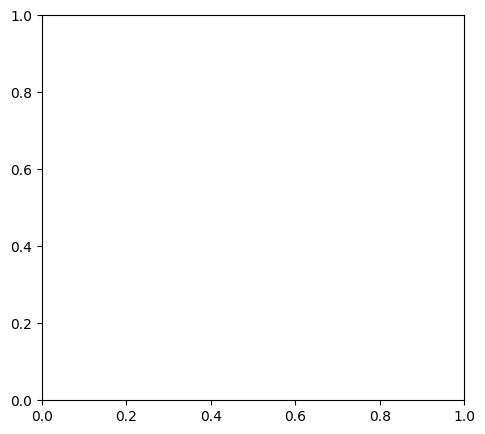

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout,
    UpSampling2D, concatenate, BatchNormalization, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.filters import threshold_otsu  # Import Otsu's thresholding

# Define input image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Resized for uniformity
IMG_CHANNELS = 1  # Grayscale images

# Directories
train_frames_dir = "/kaggle/working/train/frames"
train_masks_dir = "/kaggle/working/train/masks"
validation_frames_dir = "/kaggle/working/validation/frames"
validation_masks_dir = "/kaggle/working/validation/masks"

# Function to load and preprocess images
def load_images(image_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    for img_file in tqdm(image_files, desc=f"Loading data from {os.path.basename(image_dir)}"):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)

        # Load image and mask
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")

        # Convert to numpy arrays and normalize images
        img_array = img_to_array(img) / 255.0

        # Convert mask to array without normalization for thresholding
        mask_array = img_to_array(mask).astype('uint8').squeeze()  # Remove channel dimension

        # Apply Otsu's thresholding to the mask
        thresh = threshold_otsu(mask_array)
        binary_mask = (mask_array > thresh).astype(np.float32)  # Convert to float32 for compatibility

        # Expand dimensions to match expected shape (height, width, channels)
        binary_mask = np.expand_dims(binary_mask, axis=-1)

        images.append(img_array)
        masks.append(binary_mask)

    return np.array(images), np.array(masks)

# Load datasets with Otsu's thresholding applied to masks
X_train, y_train = load_images(train_frames_dir, train_masks_dir)
X_val, y_val = load_images(validation_frames_dir, validation_masks_dir)

# Define U-Net model with Batch Normalization
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # Encoder path
    # Block 1
    c1 = Conv2D(64, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D(2)(c1)
    
    # Block 2
    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D(2)(c2)
    
    # Block 3
    c3 = Conv2D(256, 3, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D(2)(c3)
    
    # Block 4
    c4 = Conv2D(512, 3, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D(2)(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, 3, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, 3, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    # Decoder path
    # Block 6
    u6 = UpSampling2D(2)(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, 3, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    # Block 7
    u7 = UpSampling2D(2)(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, 3, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    # Block 8
    u8 = UpSampling2D(2)(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, 3, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    
    # Block 9
    u9 = UpSampling2D(2)(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, 3, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model with binary crossentropy (consider changing to a combined loss later)
model = unet_model()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, iou_coefficient])

# Set up callbacks
callbacks = [
    lr_scheduler,
    early_stopping,
    checkpoint
]

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,  # Possibly increase epochs with early stopping in place
    callbacks=callbacks,
    verbose=1
)

# Plotting training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Script 5: Predicting and Displaying Results on Test Set

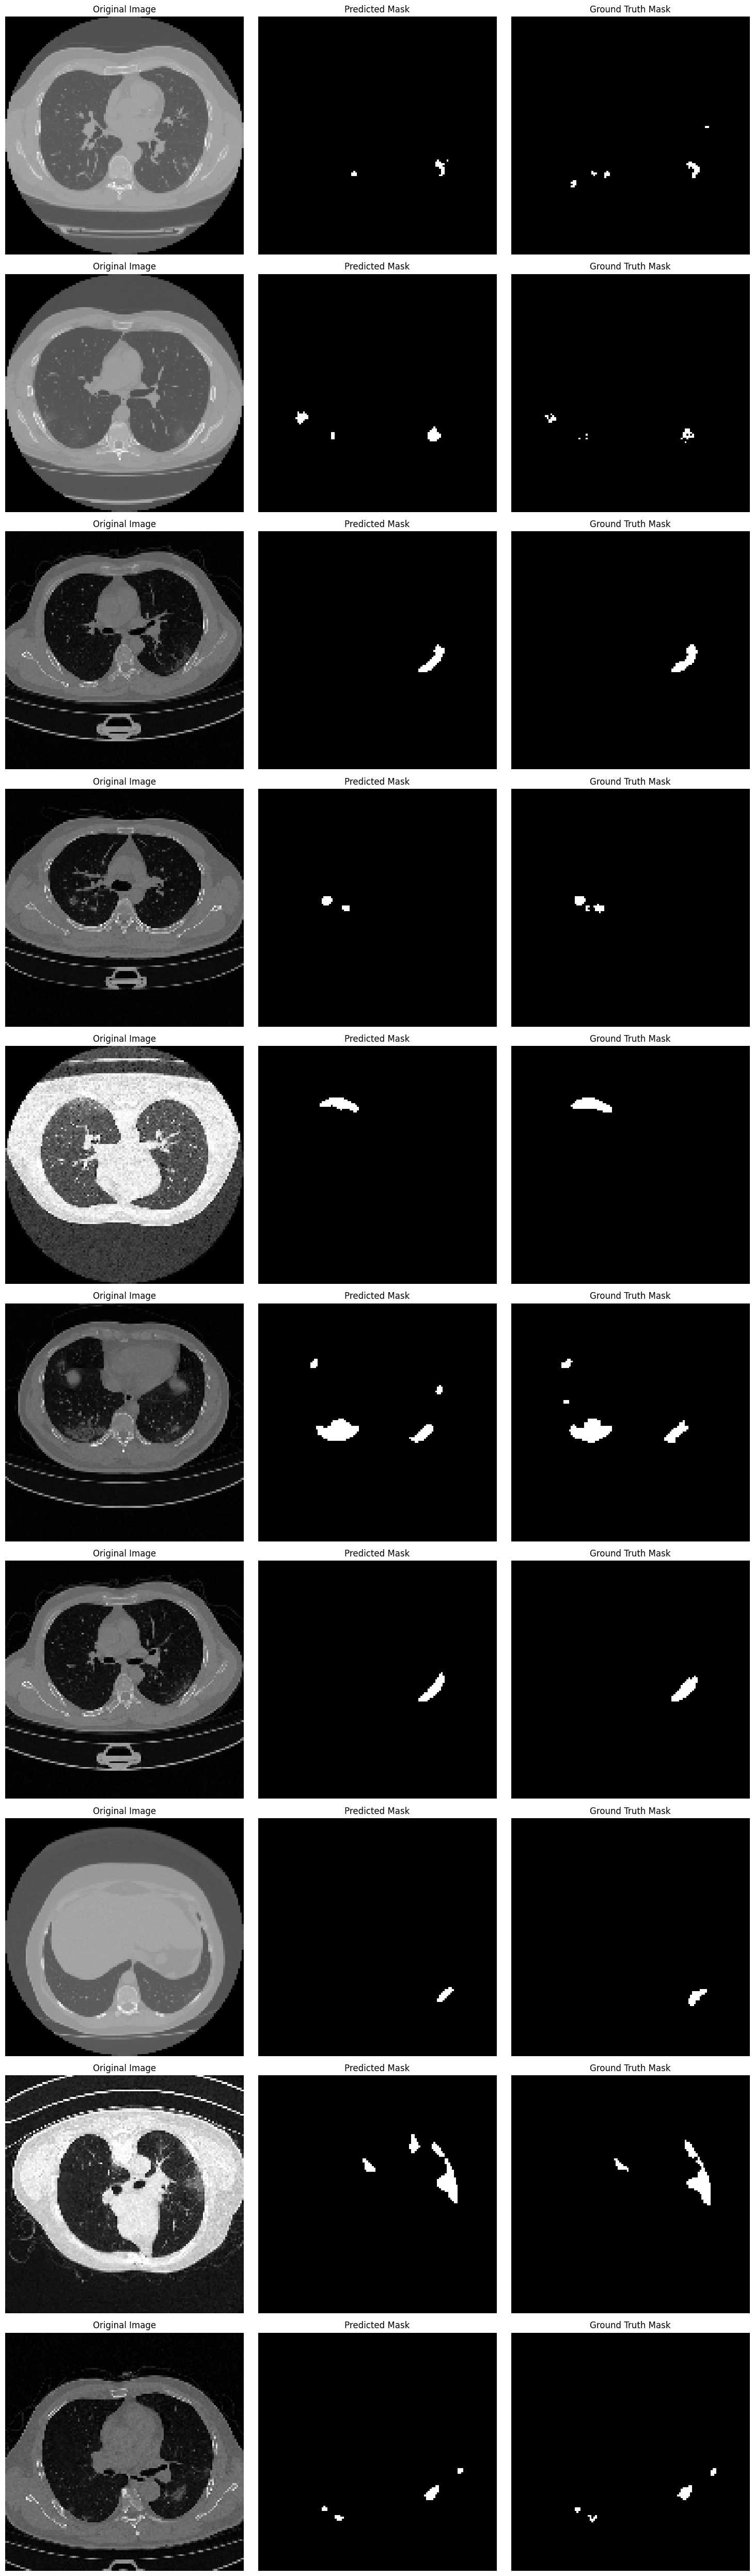

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.filters import threshold_otsu  # Import Otsu's thresholding

# Test dataset directories
test_frames_dir = "/kaggle/working/test/frames"
test_masks_dir = "/kaggle/working/test/masks"

# Load and preprocess a test image and its corresponding mask
def load_test_image(file_name):
    img_path = os.path.join(test_frames_dir, file_name)
    mask_path = os.path.join(test_masks_dir, file_name)
    
    # Load image and mask
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    mask = load_img(mask_path, target_size=(128, 128), color_mode='grayscale')
    
    # Convert to numpy arrays
    img_array = img_to_array(img) / 255.0  # Normalize image
    
    # Convert mask to array without normalization for thresholding
    mask_array = img_to_array(mask).astype('uint8').squeeze()  # Remove channel dimension
    
    # Apply Otsu's thresholding to the mask
    thresh = threshold_otsu(mask_array)
    binary_mask = (mask_array > thresh).astype(np.float32)
    
    # Expand dimensions to match expected shape (height, width, channels)
    binary_mask = np.expand_dims(binary_mask, axis=-1)
    
    return img_array, binary_mask

# Make predictions on the image
def predict_mask(model, img_array):
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_array_expanded, verbose=0)
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch dimension and channel
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Apply threshold
    return predicted_mask

# Function to display random predictions
def display_random_predictions(model, num_images=10):
    test_image_files = os.listdir(test_frames_dir)
    selected_files = random.sample(test_image_files, min(num_images, len(test_image_files)))
    
    plt.figure(figsize=(15, 5 * num_images))
    
    for idx, file_name in enumerate(selected_files):
        # Load the image and its mask
        img_array, ground_truth_mask = load_test_image(file_name)
        predicted_mask = predict_mask(model, img_array)
        
        # Plot the results
        plt.subplot(num_images, 3, idx * 3 + 1)
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(num_images, 3, idx * 3 + 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.subplot(num_images, 3, idx * 3 + 3)
        plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display predictions
display_random_predictions(model, num_images=10)


# Script 6: Quantitative Evaluation of Model Performance on Test Set

In [12]:
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.filters import threshold_otsu

# Test dataset directories
test_frames_dir = "/kaggle/working/test/frames"
test_masks_dir = "/kaggle/working/test/masks"

# Function to load and preprocess a test image and its corresponding mask
def load_test_image(file_name):
    img_path = os.path.join(test_frames_dir, file_name)
    mask_path = os.path.join(test_masks_dir, file_name)
    
    # Load image and mask
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    mask = load_img(mask_path, target_size=(128, 128), color_mode='grayscale')
    
    # Convert to numpy arrays
    img_array = img_to_array(img) / 255.0  # Normalize image
    
    # Convert mask to array without normalization for thresholding
    mask_array = img_to_array(mask).astype('uint8').squeeze()  # Remove channel dimension
    
    # Apply Otsu's thresholding to the mask
    thresh = threshold_otsu(mask_array)
    binary_mask = (mask_array > thresh).astype(np.uint8)
    
    return img_array, binary_mask

# Function to predict mask
def predict_mask(model, img_array):
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_array_expanded, verbose=0)
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch dimension and channel
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Apply threshold
    return predicted_mask

# Initialize lists to store metric values
dice_scores = []
iou_scores = []
accuracies = []
precisions = []
recalls = []

# List of test image files
test_image_files = os.listdir(test_frames_dir)

# Iterate over test set
for file_name in tqdm(test_image_files, desc="Evaluating on test set"):
    # Load image and ground truth mask
    img_array, ground_truth_mask = load_test_image(file_name)
    ground_truth_mask = ground_truth_mask.flatten()  # Flatten to 1D array

    # Predict mask
    predicted_mask = predict_mask(model, img_array)
    predicted_mask = predicted_mask.flatten()

    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    TP = np.sum((ground_truth_mask == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth_mask == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth_mask == 1) & (predicted_mask == 0))
    TN = np.sum((ground_truth_mask == 0) & (predicted_mask == 0))

    # Calculate metrics
    dice_score = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    iou_score = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Append metrics
    dice_scores.append(dice_score)
    iou_scores.append(iou_score)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Compute average metrics
avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the results
print("\nQuantitative Evaluation on Test Set:")
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")


Evaluating on test set: 100%|██████████| 273/273 [00:18<00:00, 14.62it/s]


Quantitative Evaluation on Test Set:
Average Dice Coefficient: 0.7451
Average IoU Score: 0.6394
Average Accuracy: 0.9958
Average Precision: 0.8010
Average Recall: 0.7360
